# Сборный проект № 1. Исследование продаж игр для ПК и игровых консолей

   Анализ интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).   
Выявим определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
  
  В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».  
  В работе - данные до 2016 года.   
  В датасете представлены следующие данные:
  Name	Platform - игровая платформа;  
  Year_of_Release - год выхода игры;  
  Genre - жанры;  
  NA_sales - продажи в Северной Америке;  
  EU_sales - продажи в Европе;  
  JP_sales - продажи в Японии;  
  Other_sales - продажи на других континетах (странах);  
  Critic_Score - оценка проф. критиков;  
  User_Score - оценка пользователей;  
  Rating - рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Аналитическую работу проведем в несколько этапов:  
1. Подготовим данные к исследованию;
2. Проведем исследовательский анализ данных;  
3. Составим портрет пользователя каждого региона;  
4. Выдвинем и проверим несколько гипотез.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
from io import BytesIO
import requests

### Шаг 1. Загрузка данных

Ознакомимся с представленными данными.

In [2]:
spreadsheet_id = '1KO3VWmcpwBTcFxsAOUCbv8tm10ckWv9PNreQwqmfPUc'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))
display(data.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Шаг 2. Предобработка данных

1. Проведем предобработку данных. Для этого изучим общую информацию о содержимом датафрейма.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датасет содержит сведения о 16713 играх, вышедших в разное время.  

2. Нужно привести наименование колонок к "змеиному регистру"

In [4]:
data = data.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release',
                            'Genre':'genre', 'Other_sales':'other_sales', 'Critic_Score':'critic_score',
                            'User_Score':'user_score', 'Rating':'rating'})

2. Проверим данные на отсутсвующие значения.

In [5]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В 2 случаях отсутсвует наименование игры. Т.к. наименование не является важным критерием при проведении исследования, заменим отсутсвующие имена значениеь 'name'.

In [7]:
data['name'] = data['name'].fillna('name')

В столбце "Year_of_Release" пропущено 269 значений. Эти данные необходимы для исследования. Но заполнить их какими-либо значениями нет возможности, т.к. нет достоверных сведений. Так же пропущено 2 значения о жанре игры. Удалим эти строки. Потеря данных будет не существенной.

In [8]:
data = data.dropna(subset=['year_of_release', 'genre'])

In [9]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
NA_sales              0
EU_sales              0
JP_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

3. Так же заменим тип данных в столбце 'year_of_release' с float64 на int, т.к. год выхода - это целое число. 

In [10]:
data['year_of_release'] = data['year_of_release'].astype(int)

4. Ознакомимся с уникальными значениями столбца 'user_score': 

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо числовых значений и пропущенных значений Nan встречается значение tbd. Данная аббревиатура расшифровывается как "To Be Determined", то есть "предстоит определить". Видимо, система собрала недостаточно отзывов для выставления оценки. Предлагаю заменить такие значения на Nan, т.к. иных способов заполнить пропуск нет.

In [12]:
data['user_score'] = data['user_score'].replace('tbd', 'NaN')

Сведения в столбце "user_score" сохранены в формате object . Для дальнейшего анализа преобразуем столбец в цифровой формат float64.

In [13]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   NA_sales         16444 non-null  float64
 5   EU_sales         16444 non-null  float64
 6   JP_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


5. Поскольку количество пропусков в колонках critic_score и user_score очень большое и причины пропусков могут быть обусловлены разными факторами, предлагаю отсутсвующие оценки критиков и пользователей заменить на 0, т.к. столбцы имеют колличественные данные. Очистка датафрейма от строк с пропущенными сведениями приведет к значительной потере данных (более 50%).

In [15]:
data['critic_score'] = data['critic_score'].fillna(0)
data['user_score'] = data['user_score'].fillna(0)

6. Просмотрим уникальные значения колонки 'rating'

In [16]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Столбец содержит буквенное обозначение рейтинга, присвоенного видеоигре организацией ESRB (всего 8 уникальных значений). Также столбец содержит пропуски (более 6600).  
Из открытых источников ознакомимся с обозначениями рейтинга:  

«EC» («Early childhood») — «Для детей младшего возраста»  
«E» («Everyone») — «Для всех» (до 1998 года - "K-A" ("Kids to Adults"))  
«E10+»(«Everyone 10 and older») — «Для всех от 10 лет и старше»  
«T» («Teen») — «Подросткам»  
«M»(«Mature») — «Для взрослых»  
«AO» («Adults Only 18+») — «Только для взрослых»  
«RP» («Rating Pending») — «Рейтинг ожидается»  

Предлагаю восполнить пропущенные значения на «unknown» — «неизвестно»

In [17]:
data['rating'] = data['rating'].fillna('unknown')

In [18]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
NA_sales           0
EU_sales           0
JP_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

7. Исследуем данные на наличие дублирующих записей.

In [19]:
data.duplicated().sum()

0

Дубликаты не выявлены.

8. Добавим сведения в таблицу о сумме общих продаж по каждой игре

In [20]:
data['total_sales'] = data['NA_sales'] + data['EU_sales'] + data['JP_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,unknown,31.38


Вывод:  
Привели имена столбцов к общему регистру.  
Проверили датафрейм на наличие дубликатов.    
Удалили строки, не имеющие название игры и жанр.  
Привели данные к нужным для анализа типам.  
Заменили значение 'tbd'.

Данные сохранены в корректных форматах и пригодны для дальнейшего анализа. 

### Шаг 3. Исследовательский анализ данных

1. Сколько игр выпускалось в разные годы. 

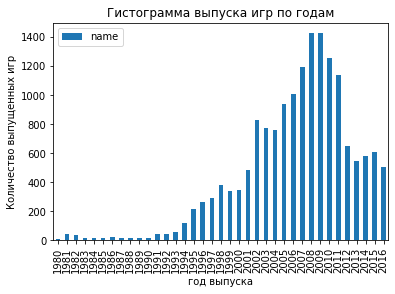

In [21]:
data.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar')
plt.ylabel('Количество выпущенных игр')
plt.xlabel('год выпуска')
plt.title('Гистограмма выпуска игр по годам')
plt.show()

Активный рост выпуска игр начинается с 1995 года. Максимальный пик приходится на 2008-2009 г.г. Далее наблюдается спад.

Важны ли данные за все периоды? - нет. Количество выпущенных игр до 1995 года - менее 500 штук, что составляет около 3% от общего числа релизов.

Для дальнейшего анализа предлагаю  отсечь период до 2000 года, т.к. до 2000 года данные малоинформативны и не дают достаточных данных для анализа перспектив.

In [22]:
data_2000 = data[data['year_of_release']>2000]

2. Оценим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.  Проанализируем, в какой характерный срок появляются новые и исчезают старые платформы.

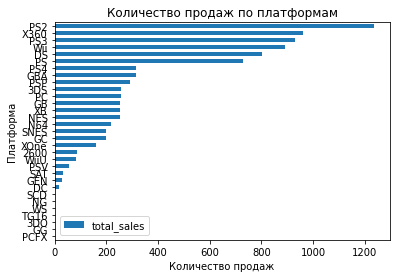

In [23]:
platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales')
platform_sales.plot(kind='barh')
plt.xlabel('Количество продаж')
plt.ylabel('Платформа')
plt.title('Количество продаж по платформам')
plt.show()

Абсолютный лидер - PS2, так же в тройку лидеров входит Х360 и PS3. После 6й позиции заметен существенный спад в количестве продаж - это или непопулярные игровые платформы, или новые релизы от лидеров, которые еще не успели завоевать рынок.

Отберем самые популярные платформы с максимальными продажами. Изучим распределение по годам. Исследуем период с 2001 по 2016 г.г.

In [24]:
platforms = data_2000[data_2000['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'])]
platforms.head()

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


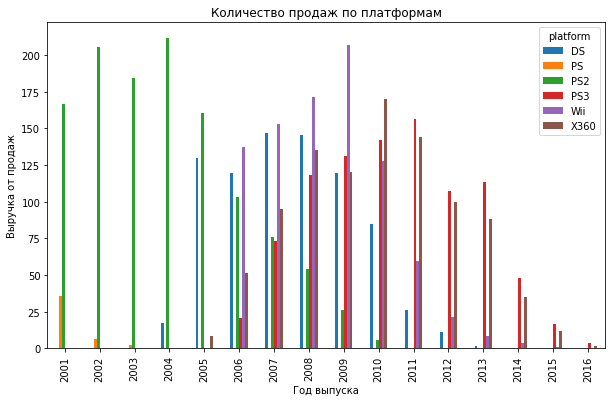

In [25]:
platforms.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(
    kind='bar', figsize=(10, 6))
plt.ylabel('Выручка от продаж')
plt.xlabel('Год выпуска')
plt.title('Количество продаж по платформам')
plt.show()

Определенно можно заявить, что практически все игровые платформы в среднем существуют до 10 лет включительно. Пик популярности наступает примерно через 5 лет после релиза. Самые успешные из исследуемых платформ: Sony Play Station и XBOX, WII (у него был резкий скачок в 2009 году и такой же резкий провал) и DS.  
Из всех этих платформ самой продаваемой по сумме продаж являлась Playstation2. На тот момент у неё не было конкурентоспособных аналогов, она в течение долгого времени занимала топовые позиции. 


3. Определим актуальный период для дальнейшего исследования.

Для дальнейшего анализа выберем данные за последние 5 лет (с 2012 года), так как они максимально отражают изменяющиеся тенденции.
Основной фактор — эти данные помогут построить прогноз на 2017 год.

In [26]:
data_2012 = data[data['year_of_release']>=2012]

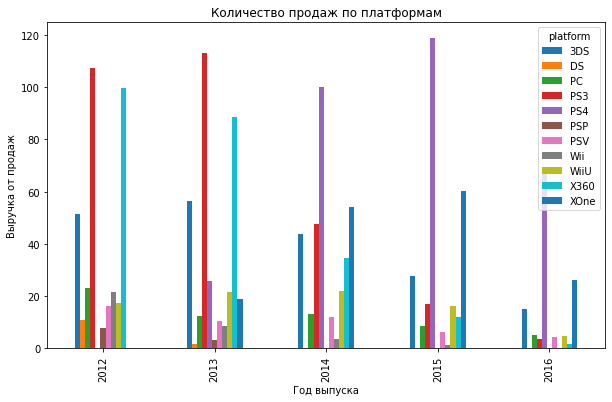

In [27]:
data_2012.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(
    kind='bar', figsize=(10, 6))
plt.ylabel('Выручка от продаж')
plt.xlabel('Год выпуска')
plt.title('Количество продаж по платформам')
plt.show()

В 2012-2013 г.г. игровая платформа PS3 набирает пик своей популярности. У нее только один явный конкурент - это Х360. К 2016 наступает закат для PS3, при этом вышедшая PS4 стремительно занимает рынок, и в 2014-2016 собирает свою максимальну. прибыль от продаж. На смену Х360 выходит XOne и так же, как и предшественник, составляет конкуренцию Sony. Тройку лидеров замыкает платформа 3DS, уверенно держащаяся на плаву в течение всех исследуемых 5 лет, хотя к концу периода продажи все же спадают.

4. Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

In [28]:
data_2012.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


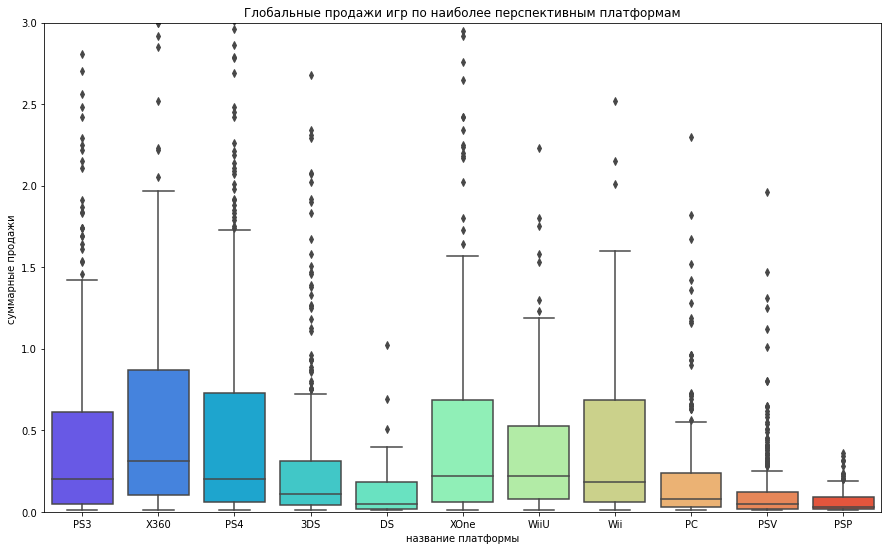

In [29]:
fig = plt.subplots(figsize=(15,9))
plt.title("Глобальные продажи игр по наиболее перспективным платформам")
plot = sns.boxplot(x="platform", y="total_sales", data=data_2012, palette='rainbow')
plt.ylim(0, 3)
plt.xlabel('название платформы')
plt.ylabel('суммарные продажи ')
plt.show()

На каждой из платформ существует большое количество игр, суммарные продажи по которым выбиваются из квартильных значений. В целом, разница в суммарных продажах игр в рамках каждой из платформ очень велико для 3DS, PS4, чуть меньше - для XOne и PS4.  

Исключим из визуализации выбивающиеся значения и построим график.  
Сравним показатели по наиболее часто встречающимся значениям: для этого нам интересны среднее, медианное и квартильные значения. 

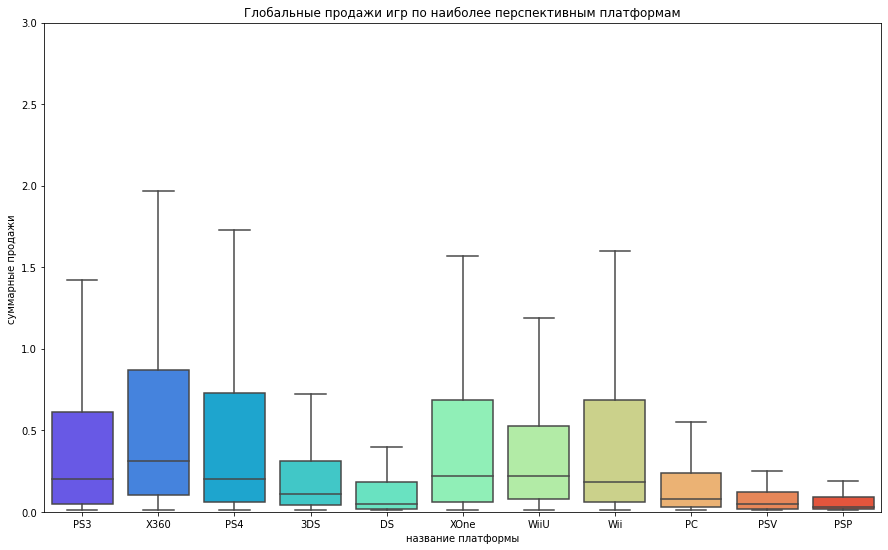

In [30]:
fig = plt.subplots(figsize=(15,9))
plt.title("Глобальные продажи игр по наиболее перспективным платформам")
plot = sns.boxplot(x="platform", y="total_sales", data=data_2012, palette='rainbow', showfliers=False)
plt.ylim(0, 3)
plt.xlabel('название платформы')
plt.ylabel('суммарные продажи ')
plt.show()

In [31]:
data_2012.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').describe()

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,5.000000,2.000000,5.000000,5.000000,4.000000,4.000000,5.000,5.000000,5.000000,5.000000,4.000000
mean,38.922000,6.275000,12.530000,57.758000,78.535000,2.797500,9.836,7.074000,16.438000,47.308000,39.830000
std,17.170394,6.696301,6.781217,50.617905,40.567917,3.547942,4.724,8.807657,7.068244,44.599522,20.313977
min,15.140000,1.540000,5.250000,3.600000,25.990000,0.120000,4.250,0.180000,4.600000,1.520000,18.960000
25%,27.780000,3.907500,8.520000,16.820000,58.435000,0.210000,6.250,1.140000,16.350000,11.960000,24.352500
50%,43.760000,6.275000,12.380000,47.760000,84.625000,1.690000,10.590,3.750000,17.560000,34.740000,40.110000
75%,51.360000,8.642500,13.280000,107.360000,104.725000,4.277500,11.900,8.590000,21.650000,88.580000,55.587500
max,56.570000,11.010000,23.220000,113.250000,118.900000,7.690000,16.190,21.710000,22.030000,99.740000,60.140000


На всех платформах наблюдается разница между средним значением и медианным: для PS4, X360 и 3DS наиболее сильно, затем WiiU и PS3 чуть меньше Также видим различия в медианных значениях: игры на PS4, X360 и XBoxOne имеют схожие графики (квартильные, средние и медианные значения).  
У явного лидера - PS4 - распределение смещено в сторону максимальных значений и это самая популярная и успешная платформа: игры, созданные для нее, продавались большими тиражами.  


5. Влияние отзывов на продажи

Предлагаю взять для анализа 2 лидера продаж: X360 и PS4.  
Построим диагармму рассеяния для отзывов пользователей и для отзывов критиков.  
Посчитаем корреляцию для отзывов пользователей и для отзывов критиков для платформы PS4 и Х360.

In [36]:
PS4_X360 = data_2012[data_2012['platform'].isin(['PS4', 'X360'])]
display(PS4_X360.head(5))

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total_sales
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,unknown,14.63
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24


In [39]:
PS4_X360 = PS4_X360[PS4_X360['user_score'] > 0]
PS4_X360 = PS4_X360[PS4_X360['critic_score'] > 0]

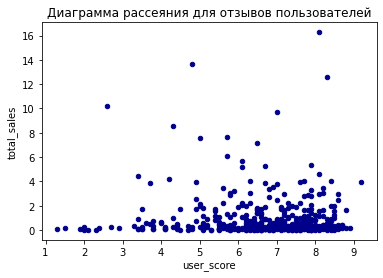

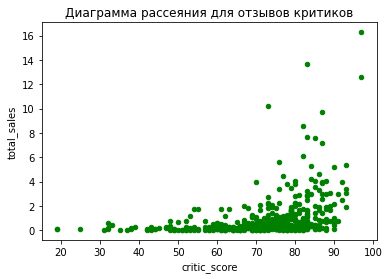

In [66]:
PS4_X360.plot(x='user_score', y='total_sales', kind='scatter', color = 'DarkBlue',
              title='Диаграмма рассеяния для отзывов пользователей')
plt.show()
PS4_X360.plot(x='critic_score', y='total_sales', kind='scatter', color = 'Green', 
              title='Диаграмма рассеяния для отзывов критиков')
plt.show()

In [44]:
#Посчитаем корреляцию для отзывов пользователей и для отзывов критиков для платформы PS4
PS4 = data_2012[data_2012['platform'] == 'PS4']
print('Значения корреляции для платформы PS4')
print('Корреляция между продажами и отзывами пользователей', PS4['total_sales'].corr(PS4['user_score']))
print('Корреляция между продажами и отзывами критиков', PS4['total_sales'].corr(PS4['critic_score']))

Значения корреляции для платформы PS4
Корреляция между продажами и отзывами пользователей 0.11311562450852881
Корреляция между продажами и отзывами критиков 0.2275496062775265


In [45]:
#Посчитаем корреляцию для отзывов пользователей и для отзывов критиков для платформы X360
X360 = data_2012[data_2012['platform'] == 'X360']
print('Значения корреляции для платформы X360')
print('Корреляция между продажами и отзывами пользователей', X360['total_sales'].corr(X360['user_score']))
print('Корреляция между продажами и отзывами критиков', X360['total_sales'].corr(X360['critic_score']))

Значения корреляции для платформы X360
Корреляция между продажами и отзывами пользователей 0.09974264797389464
Корреляция между продажами и отзывами критиков 0.26202840220219653


Согласно полученным данным по рассчету корреляции для отдельных платформ видно, что зависимость продаж от отзывов критиков больше, чем зависимость продаж от отзывов пользователей. Из графиков видно, что продажи увеличиваются с увеличением рейтинга отзыва пользователей и критиков.   
В целом, взаимосвязь слабая, или, иными словами, продажи не зависят от оценок критиков и пользователей, но к критикам прислушиваются больше.  
Все описанное для конкретной платформы, относится и ко всем остальным платформам.  

6. Распределение игр по жанрам

,total_sales
genre,
Action,441.12
Shooter,304.73
Role-Playing,192.80
Sports,181.07
Misc,85.04
Platform,61.00
Racing,53.50
Fighting,44.49
Simulation,35.12


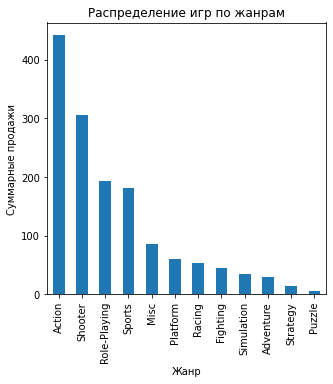

In [67]:
#Отобразим жанры по убыванию в зависимости от количества продаж
genre_2012 = data_2012.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending=False)
display(genre_2012)

# Отобразим данные в виде графика
genre_2012.plot(y='total_sales',kind='bar', legend = False, figsize = (5,5))
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи')
plt.title('Распределение игр по жанрам')
plt.show()


In [47]:
data_2012.groupby('genre')['total_sales'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Shooter,235.0,1.296723,2.251662,0.01,0.135,0.440,1.4800,14.63
Platform,85.0,0.717647,1.364413,0.01,0.090,0.210,0.6600,9.90
Sports,268.0,0.675634,1.136378,0.01,0.080,0.240,0.7425,8.58
Role-Playing,370.0,0.521081,1.315937,0.01,0.060,0.140,0.4075,14.60
Racing,115.0,0.465217,0.888664,0.01,0.050,0.140,0.4200,7.09
Misc,192.0,0.442917,1.081047,0.01,0.030,0.120,0.3375,9.18
Simulation,80.0,0.439000,1.244500,0.01,0.030,0.120,0.3275,9.17
Action,1031.0,0.427856,1.166504,0.01,0.030,0.120,0.3900,21.05
Fighting,109.0,0.408165,0.910385,0.01,0.060,0.130,0.3600,7.55


Самым продаваемым жанром является "Экшн". Возможно,  прибыльность жанра связана с продажей нескольких выбивающихся, дорогих игр. На втором месте по доходу за анализируемый актуальный период находится жанр "Шутер", это направление игр, пользующееся высоким спросом. Очень много покупателей покупают отдельные игры с высокой ценой, а значит, это перспективное направление для продажи.

Стратегии принесли самый низкий доход, но это не значит, что покупатели приобретают в этом жанре самые дешевые игры, в сравнении с другими жанрами.  Жанр "Приключения" имеет схожую со "Стратегией" характеристику по продаваемости: они слабо продаются и принесли минимальный доход, это не самые перспективные жанры.

Самым неперспективным жанром игр для продаж является "Паззлы". Он на последнем месте по суммарным продажам.

При исследовании данных мы рассмотрели продажи игр по годам, определили среднюю продолжнительность жизни платформы, определили  потенциально прибыльные платформы, рассмотрели их корреляцию с рейтингом пользователей и экспертов. Рассмотрели продажи игр в зависимости от жанра.  
Обобщив результаты, можно сказать, что, потенциально прибыльные игры должны быть на платформах - XOne, PS4, 3DS, с жанром Shooter, Action и Role-Playing.

### Шаг 4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP): самые популярные платформы (топ-5) и самые популярные жанры (топ-5).

Северная Америка (NA)

In [48]:
sales_NA = data_2012.pivot_table(index = 'platform', values = 'NA_sales', aggfunc = 'sum').sort_values(
    by = 'NA_sales', ascending=False)
print('Топ-5 платформ в Северной Америке')
display(sales_NA.head(5))

Топ-5 платформ в Северной Америке


,NA_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


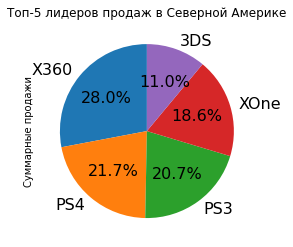

In [49]:
top_5_na = sales_NA.head(5)
top_5_na.plot(kind='pie', y='NA_sales', autopct='%1.1f%%', startangle=90, fontsize=16, legend=False) 
plt.ylabel('Суммарные продажи')
plt.title('Топ-5 лидеров продаж в Северной Америке')
plt.show()

В Северной Америке наиболее продаваемыми играми за анализируемый период являются игры на платформе PS4 и X360. Х360 является американским продуктом, и неудивительно, что завоевала рынок. Широкий выбор предлагаемых игр на популярных платформах помогает делать высокие продажи.

Европа (EU)

In [50]:
EU_sales = data_2012.pivot_table(index = 'platform', values = 'EU_sales', aggfunc = 'sum').sort_values(by = 'EU_sales', ascending=False)
print('Топ-5 платформ в Европе')
display(EU_sales.head(5))

Топ-5 платформ в Европе


,EU_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64


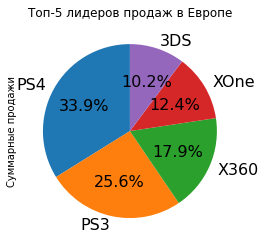

In [51]:
top_5_eu = EU_sales.head(5)
top_5_eu.plot(kind='pie', y='EU_sales', autopct='%1.1f%%', startangle=90, fontsize=16, legend=False) 
plt.ylabel('Суммарные продажи')
plt.title('Топ-5 лидеров продаж в Европе')
plt.show()

В Европе лидерство занимают игровые платформы от Sony 3 и 4 поколения.

Япония (JP)

In [52]:
JP_sales = data_2012.pivot_table(index = 'platform', values = 'JP_sales', aggfunc = 'sum').sort_values(by = 'JP_sales', ascending=False)
print('Топ-5 платформ в Японии')
display(JP_sales.head(5))

Топ-5 платформ в Японии


,JP_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


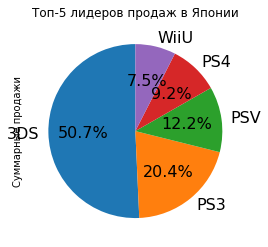

In [53]:
top_5_jp = JP_sales.head(5)
top_5_jp.plot(kind='pie', y='JP_sales', autopct='%1.1f%%', startangle=90, fontsize=16, legend=False) 
plt.ylabel('Суммарные продажи')
plt.title('Топ-5 лидеров продаж в Японии')
plt.show()

В Японии безусловным лидером продаж является их же платформа 3DS. Ближайшую конкурентную нишу занимает PS3.

По аналогии с анализом игровых платформ, проанализируем популярные жанры в доле продаж на разных континентах.

Северная Америка

Топ-5 жанров в Северной Америке


,NA_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


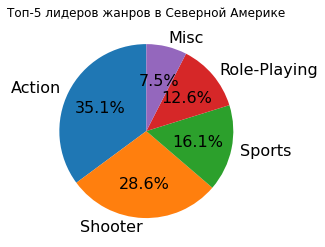

In [54]:
NA_genre = data_2012.pivot_table(index = 'genre', values = 'NA_sales', aggfunc = 'sum').sort_values(by = 'NA_sales', ascending=False)
print('Топ-5 жанров в Северной Америке')
display(NA_genre.head(5))
top_5_na_genre = NA_genre.head(5)
top_5_na_genre.plot(kind='pie', y='NA_sales', autopct='%1.1f%%', startangle=90, fontsize=16, legend=False) 
plt.ylabel(' ')
plt.title('Топ-5 лидеров жанров в Северной Америке')
plt.show()

Европа

In [55]:
EU_genre = data_2012.pivot_table(index = 'genre', values = 'EU_sales', aggfunc = 'sum').sort_values(by = 'EU_sales', ascending=False)
print('Топ-5 жанров в Европе')
display(EU_genre.head(5))

Топ-5 жанров в Европе


,EU_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29


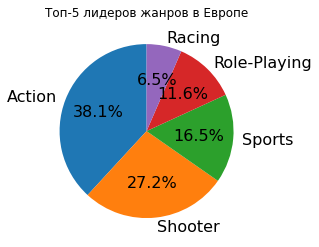

In [56]:
top_5_eu_genre = EU_genre.head(5)
top_5_eu_genre.plot(kind='pie', y='EU_sales', autopct='%1.1f%%', startangle=90, fontsize=16, legend=False) 
plt.ylabel(' ')
plt.title('Топ-5 лидеров жанров в Европе')
plt.show()

В европейских странах и на Северо-Американском континенте больше всего играют в 'Action', 'Shooter'  и 'Sports'.

Япония

Топ-5 жанров в Японии


,JP_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


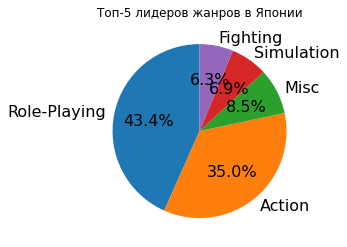

In [57]:
JP_genre = data_2012.pivot_table(index = 'genre', values = 'JP_sales', aggfunc = 'sum').sort_values(by = 'JP_sales', ascending=False)
print('Топ-5 жанров в Японии')
display(JP_genre.head(5))
top_5_jp_genre = JP_genre.head(5)
top_5_jp_genre.plot(kind='pie', y='JP_sales', autopct='%1.1f%%', startangle=90, fontsize=16, legend=False) 
plt.ylabel(' ')
plt.title('Топ-5 лидеров жанров в Японии')
plt.show()

В Японии предпочитают Role-Playing и Action. Остальные жанры не пользуются такой сильной популярностью.

##### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [58]:
na_rating_sales = (data_2012
                                .pivot_table(index='rating', values='NA_sales', aggfunc='sum')
                                .sort_values(by='NA_sales', ascending=False)
                                .reset_index()
                   )
na_rating_sales['NA_ratio'] = round(na_rating_sales['NA_sales'] / sum(na_rating_sales['NA_sales']), 3)
na_rating_sales

,rating,NA_sales,NA_ratio
0,M,231.57,0.392
1,E,114.37,0.194
2,unknown,103.31,0.175
3,E10+,75.70,0.128
4,T,66.02,0.112


В Северной Америке наиболее продаваемыми играми за анализируемый период являются игры c рейтингом M ("для взрослых") - 39% от продаж;

на втором месте игры с рейтингом E ("для всех") - 19.4%;

на третьем месте игры , которые мы пометили, как неопределенный рейтинг - 17.5% 

на четвёртом месте игры с рейтингом E10+ ("для всех от 10 лет и старше") - почти 13%; 

на пятом месте игры с рейтингом T ("подросткам") - 11%.  


In [59]:
eu_rating_sales = (data_2012
                                .pivot_table(index='rating', values='EU_sales', aggfunc='sum')
                                .sort_values(by='EU_sales', ascending=False)
                                .reset_index()
                   )
eu_rating_sales['EU_ratio'] = round(eu_rating_sales['EU_sales'] / sum(eu_rating_sales['EU_sales']), 3)
eu_rating_sales

,rating,EU_sales,EU_ratio
0,M,193.96,0.383
1,E,113.03,0.223
2,unknown,91.50,0.181
3,E10+,55.37,0.109
4,T,52.96,0.104


In [60]:
jp_rating_sales = (data_2012
                                .pivot_table(index='rating', values='JP_sales', aggfunc='sum')
                                .sort_values(by='JP_sales', ascending=False)
                                .reset_index()
                   )
jp_rating_sales['JP_ratio'] = round(jp_rating_sales['JP_sales'] / sum(jp_rating_sales['JP_sales']), 3)
jp_rating_sales

,rating,JP_sales,JP_ratio
0,unknown,108.84,0.565
1,E,28.33,0.147
2,T,26.02,0.135
3,M,21.20,0.110
4,E10+,8.19,0.043


В Японии больше половины игр не имеют рейтинга, т.к. в стране используется свой национальный рейтинг для классификации игр по возратсным ограничениям.   

Таким образом, в Северной Америке и Европе схожая структура продаж по рейтингу игр. В Японии предпочтения отличаются: подростковые игры более популярны, чем игры для взрослых. На игры для детей младшего возраста нет спроса ни в одном регионе.

Сложно сказать о каком-либо влиянии, т.к. прямой зависимости от оценок пользователей и критиков ранее не было выявлено. Думаю, что рейтинг от ESRB так же не оказывает существенного влияния на объем продаж.

### Шаг 5. Проверка статистических гипотез

#### Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC

Сделаем выборки для проверки гипотез. Отберем данные по выбранным платформам, и будем учитывать только те игры, которые имеют оценку пользователя.

In [61]:
xboxone = data_2012[(data_2012['platform'] == 'XOne') & (data_2012['user_score'] > 0)]['user_score']
pc_games = data_2012[(data_2012['platform'] == 'PC') & (data_2012['user_score'] > 0)]['user_score']

Сформулируем нулевую гипотезу H0: Средние двух генеральных совокупностей равны между собой.

Альтернативная гипотеза H1: Средние двух генеральных совокупностей не равны между собой.

Согласно центральной предельной теореме, выборочные средние распределены нормально вокруг истинного среднего генеральной совокупности. Введём уровень значимости, определяющий близость к среднему значению: 5%.

Проверим гипотезы через распределение t-Стьюдента, так как сравниваемые выборки независимы между собой.

In [62]:
alpha = 0.05

results = st.ttest_ind(xboxone, pc_games)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу.


In [63]:
xboxone.mean(), pc_games.mean()

(6.521428571428572, 6.4286407766990274)

Вывод: средние пользовательские рейтинги платформ Xbox One и PC равны между собой.

#### Гипотеза о различии средних пользовательских рейтингов жанров Action и Sports

По аналогии с предыдущей гипотезой сделаем выборки:

In [64]:
action = data_2012[(data_2012['genre'] == 'Action') & (data_2012['user_score'] > 0)]['user_score']
sports = data_2012[(data_2012['genre'] == 'Sports') & (data_2012['user_score'] > 0)]['user_score']

Сформулируем нулевую гипотезу H0: Средние двух генеральных совокупностей равны между собой.

Альтернативная гипотеза H1: Средние двух генеральных совокупностей не равны между собой.

In [65]:
alpha = 0.05

results = st.ttest_ind(action, sports)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Вывод: средние пользовательские рейтинги жанров Action и Sports не равны.

Для проверки обоих гипотез был выбрана гипотеза о равенстве средних двух генеральных совокупностей. В первом и втором случае имеются две независимые генеральные совокупности. В результате получили, что гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые - не отвергается. А гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные - потвердилась.

### Шаг 6. Oбщий вывод

1. Перед анализом данных, была проведена предобработку данных: приведены имена столбцов к нижнему регистру , где требовалось был изменен тип данных. Удалены пропуски в столбцах. Отсутсвующие значения заполнены по мере возможности. Проведена проверка на дубликаты.  
2. Установлено, что аббревиатура TBD значит "to be determined". Поэтому  tbd было заменено на nan для проведения дальнейшего анализа.  
3. Проводя анализ, выявлено, что быстрый рост выпуска игр начинается с 1995 года. Пик на консольные и компьютерный игры приходится на 2008-2009 года, далее начинается спад.Самые популярные игровые платформы за все время: PS, DS, WII, PS3, X360, PS2. Практически все игровые платформы в среднем существуют около 10 лет. Самый пик для игры наступает примерно в середине жизни пплатформы. PC самая долгоживущая платформа. Актуальный период для прогноза на 2017 взяли с 2012 по 2016 года. Данный период выбран в связи с тем, что уже остались только актуальные платформы.  

По данным видно, что практически все платформы находятся в стадии снижения показателей. Потенциально прибыльными платформами можно считать: PS4, XONE.
Оцека критиками и оценка пользователями не оказывает особого влияния на продажи на рынках в Европе и Америке, при этом  пользовательские оценки в Японии имеют некоторое влияние.
Так же установлено, что рынки Америки и Европы схожи, а вот рынок Японии в некотором смысле уникален, со своими рейтингами, жанрами, платформами.  

Согласно полученным данным, можно сделать следующий вывод: чтобы успешно продавать игры в 2017 году,  необходимо следовать следующим тенденциям.  
* обращать внимание на жанр игры (для Японии лучше продвать игры жанра role-playing, а для Северной Америки и Европы продавать игры жанров - action, sports и shooter).  
* также необходимо ориентироваться на платформы. Для Северной Америки - это платформа Xbox 360 и платформа Xbox one, для Европы - это Xbox 360/one и PS3/4, а вот в Японии - это DS/3DS и PS3/4.   
* можно предположить, что самые перспективные платформы для продаж игр на 2017 год являются Xbox Оne и PS4, так как они имели самые высокие показатели по продажам игр в 2016 году.
* ориентироваться при продаже игр на пользовательские оценки не стоит. И не придавать большого значения оценкам критиков, но принимать их во внимание;  
* учитывая, что срок жизни платформы составляет 8-10 лет, не продавать игры на платформах, для которых этот срок приближается к 6-8 годам, так как основной доход можно получить от продаж игр на более молодых платформах, а не доживающих свой век.